# Imports

In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LogNorm
import IPython.display as pyDisplay
import matplotlib.transforms as transforms 
import scipy.special as sciSpec
import subprocess
import tfs

from cpymad.madx import Madx
import Backend.Constants as cst
import Backend.WCTools as WCTools
import Backend.MADXTools as MADXTools

#import xline as xl
#import xobjects as xo
#import xtrack as xt
#import xpart as xp

# Utilities

In [2]:
def plotKick(x,y,DPx,DPy,title='',ax=None,**kwargs):
    if ax is None:
        ax = plt.gca()
    plt.title(title,fontsize=25)
    arrowLength = 0.5*np.max(np.diff(np.sort(x/1e-3)))

    for _x,_y,_DPx,_DPy in zip(x,y,DPx,DPy):
        thisNorm = WCTools.vecNorm([ _DPx,_DPy])
        plt.arrow(_x/1e-3, _y/1e-3, _DPx/thisNorm*arrowLength, _DPy/thisNorm*arrowLength,head_width=0.1, head_length=0.1)

    plt.scatter(x/1e-3,y/1e-3,c=WCTools.vecNorm([DPx,DPy]),zorder=len(x)+1,**kwargs)
    cbar = plt.colorbar()
    cbar.set_label('Kick',fontsize=20)
    plt.xlabel('x [mm]',fontsize=20)
    plt.ylabel('y [mm]',fontsize=20)
    plt.axis('square')
    
    
def importTRK(filename):
    with open(filename, "r+") as f:
        content = f.readlines()
        f.seek(0)
        for line in content:
            if '#segment' not in line:
                f.write(line)
        f.truncate()

    tracked = tfs.read(filename)
    tracked.columns = tracked.columns.str.lower()
    
    return tracked

def importTwiss(filename):
    twiss = tfs.read(filename)
    twiss.columns = list(twiss.columns.str.lower())
    twiss.name = twiss.name.str.lower()
    twiss.keyword = twiss.keyword.str.lower()
    
    return twiss

def PLOTFODO(twiss,title=''):
    # Plotting beta function
    #---------------------------    
    
    plt.title(title,loc='left')
    axLeft = plt.gca()
    h1, = plt.plot(twiss['s'],twiss['betx'],'b-',label=r'$\beta_x$')
    h2, = plt.plot(twiss['s'],twiss['bety'],'r-',label=r'$\beta_y$')
    plt.ylabel(r'$\beta$ [m]')

    axRight = plt.twinx()
    h3, = plt.plot(twiss['s'],twiss['dx'],'g-',label=r'$D_x$')
    h4, = plt.plot(twiss['s'],twiss['dy'],'y-',label=r'$D_y$')
    plt.legend(handles=[h1,h2,h3,h4],ncol=4,loc='upper center', bbox_to_anchor=(0.5, 1.12))
    plt.ylabel(r'$D$ [m]')

    plt.xlabel('s [m]')


    # Adding Quad strength
    #--------------------------- 
    axOff = axLeft.twinx()
    plt.plot(twiss['s'],0*twiss['s'],'k')
    MADXTools.plotElements(twiss,ax=axOff)
    axOff.axis('off')
    #plt.ylim([-0.01,0.01])

 ## `__repr__`

In [2]:
def custom_repr(self):
    repr = ''
    repr +='cpymad.madx.Madx Object\n'
    repr +=40*'='+'\nself.sequence\n' + 40*'='+'\n'
    repr +=str(pd.Series(self.sequence))
    
    repr +='\n'+40*'='+'\nself.globals\n' + 40*'='+'\n'
    repr +=str(pd.Series(self.globals))
    print(repr)
    #return repr

# LHC sequence

The original sequence file was taken from:

`/afs/cern.ch/eng/lhc/optics/lhc_current/lhc_as-built.seq`

And the magnet strength is contained in:

`/afs/cern.ch/eng/lhc/optics/lhc_current/opt_400_10000_400_3000.madx`

In [41]:
# Importing LHC sequences:
mad = Madx()
mad.option(echo = True, warn = True)
mad.call(file='lhc_as-built.seq')
mad.call(file='/afs/cern.ch/eng/lhc/optics/lhc_current/opt_400_10000_400_3000.madx')

# Adding repr method to visualise the mad instance
mad.__repr__ = custom_repr.__get__(mad)
mad.__repr__()

cpymad.madx.Madx Object
self.sequence
lhcb1    <Sequence: lhcb1>
lhcb2    <Sequence: lhcb2>
dtype: object
self.globals
version       50700.000000
pi                3.141593
twopi             6.283185
degrad           57.295780
raddeg            0.017453
                  ...     
kqt12.r7b2       -0.002814
kqt13.l7b1       -0.000034
kqt13.l7b2       -0.000686
kqt13.r7b1        0.000468
kqt13.r7b2       -0.000281
Length: 1415, dtype: float64


In [42]:
# Adding beam and extracting twiss table
mad.command.beam(particle='proton',charge=1,npart=1,energy=7000)
mad.sequence.lhcb1.use()
mad.twiss()
twiss = mad.table['twiss'].dframe()

twiss.groupby('keyword').count()

name     s  betx  alfx   mux  bety  alfy   muy     x    px  ...  \
keyword                                                                  ...   
drift        6590  6590  6590  6590  6590  6590  6590  6590  6590  6590  ...   
hkicker       280   280   280   280   280   280   280   280   280   280  ...   
instrument     60    60    60    60    60    60    60    60    60    60  ...   
marker         77    77    77    77    77    77    77    77    77    77  ...   
monitor       587   587   587   587   587   587   587   587   587   587  ...   
multipole    1267  1267  1267  1267  1267  1267  1267  1267  1267  1267  ...   
octupole      166   166   166   166   166   166   166   166   166   166  ...   
placeholder    58    58    58    58    58    58    58    58    58    58  ...   
quadrupole    838   838   838   838   838   838   838   838   838   838  ...   
rbend          60    60    60    60    60    60    60    60    60    60  ...   
rcollimator    90    90    90    90    90    90    90    90    90    90  ...   
rfcavity        8     8     8     8     8     8     8     8     8     8  ...   
sbend        1232  1232  1232  1232  1232  1232  1232  1232  1232  1232  ...   
sextupole    1604  1604  1604  1604  1604  1604  1604  1604  1604  1604  ...   
solenoid        6     6     6     6     6     6     6     6     6     6  ...   
tkicker        64    64    64    64    64    64    64    64    64    64  ...   
vkicker       280   280   280   280   280   280   280   280   280   280  ...   

             sig54  sig55  sig56  sig61  sig62  sig63  sig64  sig65  sig66  \
keyword                                                                      
drift         6590   6590   6590   6590   6590   6590   6590   6590   6590   
hkicker        280    280    280    280    280    280    280    280    280   
instrument      60     60     60     60     60     60     60     60     60   
marker          77     77     77     77     77     77     77     77     77   
monitor        587    587    587    587    587    587    587    587    587   
multipole     1267   1267   1267   1267   1267   1267   1267   1267   1267   
octupole       166    166    166    166    166    166    166    166    166   
placeholder     58     58     58     58     58     58     58     58     58   
quadrupole     838    838    838    838    838    838    838    838    838   
rbend           60     60     60     60     60     60     60     60     60   
rcollimator     90     90     90     90     90     90     90     90     90   
rfcavity         8      8      8      8      8      8      8      8      8   
sbend         1232   1232   1232   1232   1232   1232   1232   1232   1232   
sextupole     1604   1604   1604   1604   1604   1604   1604   1604   1604   
solenoid         6      6      6      6      6      6      6      6      6   
tkicker         64     64     64     64     64     64     64     64     64   
vkicker        280    280    280    280    280    280    280    280    280   

               n1  
keyword            
drift        6590  
hkicker       280  
instrument     60  
marker         77  
monitor       587  
multipole    1267  
octupole      166  
placeholder    58  
quadrupole    838  
rbend          60  
rcollimator    90  
rfcavity        8  
sbend        1232  
sextupole    1604  
solenoid        6  
tkicker        64  
vkicker       280  

[17 rows x 255 columns]

In [25]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    display(twiss[twiss['s']<500][:500])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
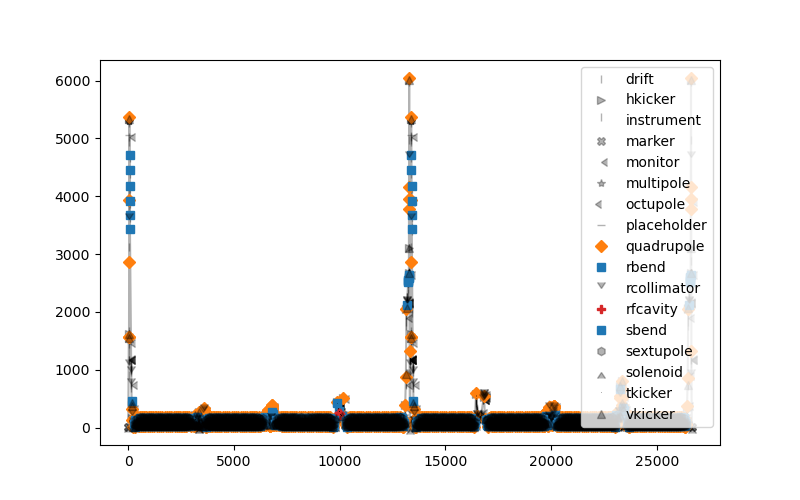

In [43]:
markerDict = {'drift':'|', 
              'hkicker':'>', 
              'instrument':2, 
              'marker':'X', 
              'monitor':4, 
              'multipole':'*', 
              'octupole':8, 
              'placeholder':'_', 
              'quadrupole':'D', 
              'rbend':'s', 
              'rcollimator':7, 
              'rfcavity':'P', 
              'sbend':'s', 
              'sextupole':'h', 
              'solenoid':6, 
              'tkicker':',', 
              'vkicker':'^'}

colorDict = dict.fromkeys(markerDict.keys(),'k')
colorDict.update({'sbend':'C0','rbend':'C0','quadrupole':'C1','rfcavity':'C3'})

#plotting:
%matplotlib widget
_groupedTwiss = twiss.groupby('keyword')
plt.figure(figsize=(8,5))
plt.plot(twiss['s'],twiss['betx'],'k',alpha=0.3)
for gr in list(_groupedTwiss.groups.keys()):
    thisAlpha = 0.3 if colorDict[gr] == 'k' else 1
    plt.plot(_groupedTwiss.get_group(gr)['s'],_groupedTwiss.get_group(gr)['betx'],alpha=thisAlpha,linestyle='None',color=colorDict[gr],marker=markerDict[gr],label=gr)
    
plt.legend()
#%matplotlib inline

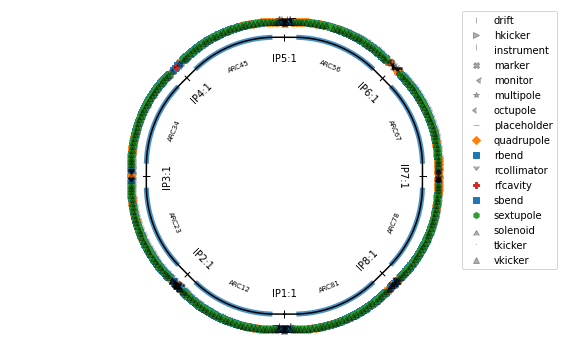

In [4]:
sequenceNames = ['lhcb1']




# Importing LHC sequences:
mad = Madx()
mad.option(echo = True, warn = True)
mad.call(file='lhc_as-built.seq')
mad.call(file='/afs/cern.ch/eng/lhc/optics/lhc_current/opt_400_10000_400_3000.madx')
mad.command.beam(particle='proton',charge=1,npart=1,energy=7000)



# Plot Survey
#%matplotlib widget
for seq in sequenceNames:
    # Generating survey
    mad.sequence[seq].use()
    mad.survey(theta0=np.pi)
    
    plt.figure(figsize=(8,5))
    survey = MADXTools.plotSurvey(mad.table['survey'].dframe())

plt.tight_layout()
plt.savefig('LHC_full.png',dpi=300)


 1e6*cst.LHC_TURN_LENGTH/60

In [16]:
 1e6*cst.LHC_TURN_LENGTH/60

1.482080868981256

# LHC Skeleton

In [3]:
# Importing LHC sequences:
mad = Madx()
mad.option(echo = True, warn = True)
mad.call(file='lhc_as-built.seq')
mad.call(file='/afs/cern.ch/eng/lhc/optics/lhc_current/opt_400_10000_400_3000.madx')

# Adding repr method to visualise the mad instance
mad.__repr__ = custom_repr.__get__(mad)

# Adding beam and extracting twiss table
mad.command.beam(particle='proton',charge=1,npart=1,energy=7000)
mad.sequence.lhcb1.use()
mad.twiss()
twiss = mad.table['twiss'].dframe()

# Editing to remove some elements:
toKeep = twiss.keyword.str.contains('|'.join(['marker','sbend','rbend','quadrupole','rfcavity']))

# removing everything except toKeep
editable = pd.DataFrame({'name':twiss.name.str.split(':',expand=True)[0].copy()})
editable.reset_index(inplace=True,drop=True)
editable.insert(0,'mode','remove')
editable.loc[np.array(toKeep),'mode'] = 'skip'

display(editable)
mad.input(MADXTools.seqedit(sequence='lhcb1',editing=editable, makeThin = False))

# setting magnet stengths
#mad.call(file='/afs/cern.ch/eng/lhc/optics/lhc_current/opt_400_10000_400_3000.madx')

# Extracting the new twiss
mad.sequence.lhcb1.use()
mad.twiss()
twiss = mad.table['twiss'].dframe()
twiss_elements = twiss[twiss['keyword']!='drift'].copy()

mad.survey(theta0=np.pi)
survey = mad.table['survey'].dframe()


# Rotating twiss w.r.t. ip3:
#offset = twiss.loc['ip3']['s']
#twiss['s'] = np.mod(twiss['s']-offset,cst.LHC_C)
#twiss.sort_values(['s'],inplace=True)



mode         name
0        skip  lhcb1$start
1        skip          ip1
2      remove    mbas2.1r1
3      remove      drift_0
4      remove      tas.1r1
...       ...          ...
13262  remove      tas.1l1
13263  remove   drift_6589
13264  remove    mbas2.1l1
13265    skip       ip1.l1
13266    skip    lhcb1$end

[13267 rows x 2 columns]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
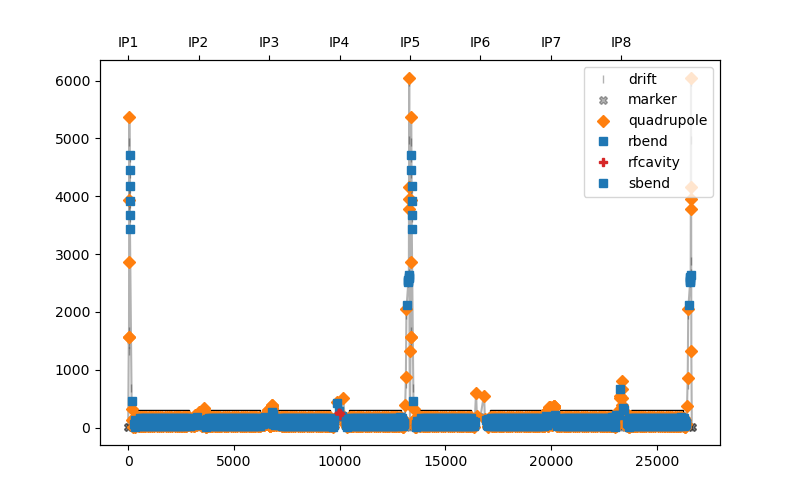

In [4]:
markerDict = {'drift':'|', 
              'hkicker':'>', 
              'instrument':2, 
              'marker':'X', 
              'monitor':4, 
              'multipole':'*', 
              'octupole':8, 
              'placeholder':'_', 
              'quadrupole':'D', 
              'rbend':'s', 
              'rcollimator':7, 
              'rfcavity':'P', 
              'sbend':'s', 
              'sextupole':'h', 
              'solenoid':6, 
              'tkicker':',', 
              'vkicker':'^'}

colorDict = dict.fromkeys(markerDict.keys(),'k')
colorDict.update({'sbend':'C0','rbend':'C0','quadrupole':'C1','rfcavity':'C3'})

#plotting:
%matplotlib widget
_groupedTwiss = twiss.groupby('keyword')
plt.figure(figsize=(8,5))
plt.plot(twiss['s'],twiss['betx'],'k',alpha=0.3)
for gr in list(_groupedTwiss.groups.keys()):
    thisAlpha = 0.3 if colorDict[gr] == 'k' else 1
    plt.plot(_groupedTwiss.get_group(gr)['s'],_groupedTwiss.get_group(gr)['betx'],alpha=thisAlpha,linestyle='None',color=colorDict[gr],marker=markerDict[gr],label=gr)
    
plt.legend()

# Adding arc delimiters:  
for i in range(0,8):
    arc = f'{np.roll(range(1,9),-i)[0]}{np.roll(range(1,9),-i)[1]}'
    
    thisArc = twiss.loc[f's.arc.{arc}.b1':f'e.arc.{arc}.b1']
    plt.gca().add_patch(patches.Rectangle((np.min(thisArc['s']),0), 
                                          np.max(thisArc['s'])-np.min(thisArc['s']), 
                                          300,
                                         facecolor='none',edgecolor='k'))
    

ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.set_xbound(ax1.get_xbound())

IP_loc = {'s':[],'label':[]}
for IP in range(1,9):
    IP_loc['s'].append(float(twiss.loc[twiss.name.str.fullmatch(f'ip{IP}:1'),'s']))
    IP_loc['label'].append(f'IP{IP}')

ax2.set_xticks(IP_loc['s']);
ax2.set_xticklabels(IP_loc['label']);


(-4625.102393118289, 4625.311472667793, -4576.925301585843, 4673.685458785008)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
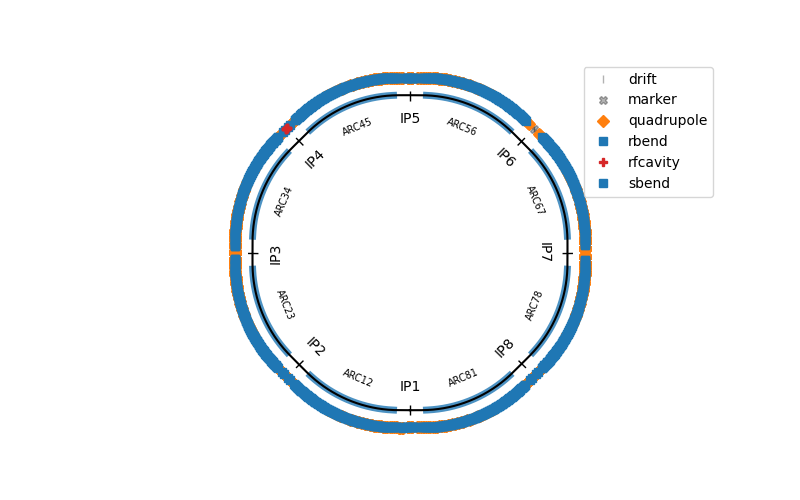

In [5]:


%matplotlib widget
# Center around 0:
survey = mad.table['survey'].dframe()

survey.loc[:,'x'] -= np.mean(survey['x'])
r, theta = WCTools.cart2pol(survey['z'],survey['x'])
survey.insert(0,'r_polar',r)
survey.insert(0,'rotation',theta)

IP_loc = survey.loc[[f'ip{IP}' for IP in range(1,9)]]
_groupedSurvey = survey.groupby('keyword')

plt.figure(figsize=(8,5))
plt.plot(survey['z'],survey['x'],'k',alpha=0.3)
for gr in list(_groupedSurvey.groups.keys()):
    thisAlpha = 0.3 if colorDict[gr] == 'k' else 1
    plt.plot(_groupedSurvey.get_group(gr)['z'],_groupedSurvey.get_group(gr)['x'],alpha=thisAlpha,linestyle='None',color=colorDict[gr],marker=markerDict[gr],label=gr)
    
# Adding s axis:
axScale = 0.9
plt.plot(axScale*survey['z'],axScale*survey['x'],'k',alpha=1)
for index, row in IP_loc.iterrows():
    plt.plot(1.01*axScale*row['z'],1.01*axScale*row['x'],'k',ms=10, mew=1,marker=(1,1,90+np.rad2deg(row['rotation'])),linestyle='None',alpha=1)
    plt.text(0.85*axScale*row['z'],0.85*axScale*row['x'],row['name'].upper(),ha='center',va='center',rotation=-90+np.rad2deg(np.mod(row['rotation'],np.pi)))

# Adding arc delemiter    
for i in range(0,8):
    arc = f'{np.roll(range(1,9),-i)[0]}{np.roll(range(1,9),-i)[1]}'
    
    thisArc = survey.loc[f's.arc.{arc}.b1':f'e.arc.{arc}.b1']
    plt.plot(axScale*thisArc['z'],axScale*thisArc['x'],'C0',alpha=0.8,lw=5,zorder=-10)
    
    plt.text(0.85*axScale*thisArc.iloc[len(thisArc)//2]['z'],0.85*axScale*thisArc.iloc[len(thisArc)//2]['x'],f'ARC{arc}',fontsize=7,ha='center',va='center',rotation=-90+np.rad2deg(np.mod(thisArc.iloc[len(thisArc)//2]['rotation'],np.pi)))
    
plt.legend()
plt.axis('equal')
plt.axis('off')

interactive(children=(IntSlider(value=0, description='Test widget:', layout=Layout(width='90%'), max=26659, st…

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
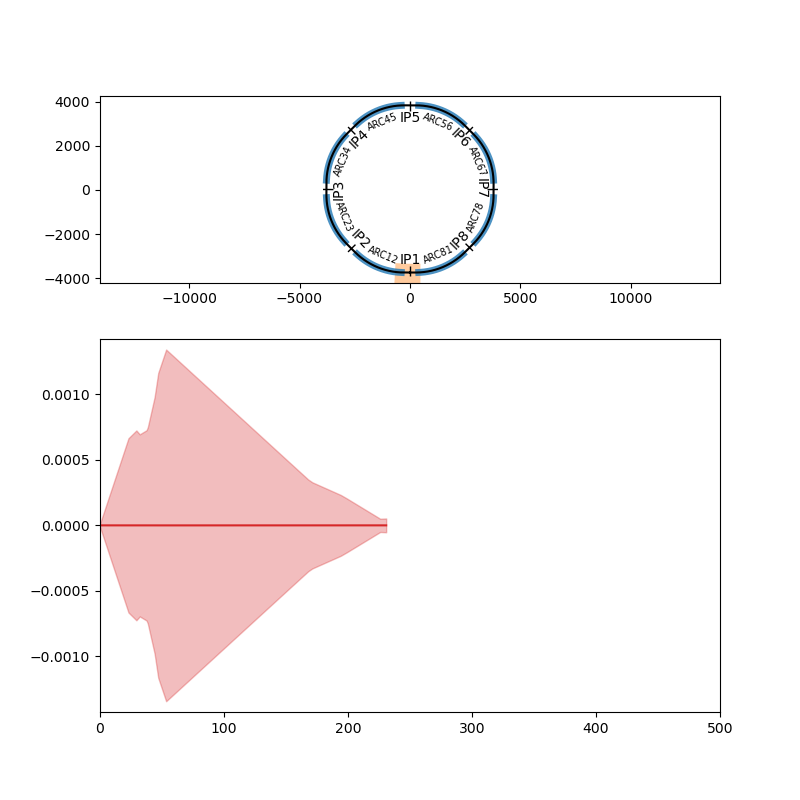

In [6]:
#from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



survey = mad.table['survey'].dframe()

survey.loc[:,'x'] -= np.mean(survey['x'])
r, theta = WCTools.cart2pol(survey['z'],survey['x'])
survey.insert(0,'r_polar',r)
survey.insert(0,'rotation',theta)

IP_loc = survey.loc[[f'ip{IP}' for IP in range(1,9)]]
_groupedSurvey = survey.groupby('keyword')







fig,axes = plt.subplots(2,1,figsize=(8,8),gridspec_kw={'height_ratios': [1, 2]})
plt.sca(axes[0])
# Adding s axis:
axScale = 0.9
plt.plot(axScale*survey['z'],axScale*survey['x'],'k',alpha=1)
for index, row in IP_loc.iterrows():
    plt.plot(1.01*axScale*row['z'],1.01*axScale*row['x'],'k',ms=10, mew=1,marker=(1,1,90+np.rad2deg(row['rotation'])),linestyle='None',alpha=1)
    plt.text(0.85*axScale*row['z'],0.85*axScale*row['x'],row['name'].upper(),ha='center',va='center',rotation=-90+np.rad2deg(np.mod(row['rotation'],np.pi)))

# Adding arc delemiter    
for i in range(0,8):
    arc = f'{np.roll(range(1,9),-i)[0]}{np.roll(range(1,9),-i)[1]}'

    thisArc = survey.loc[f's.arc.{arc}.b1':f'e.arc.{arc}.b1']
    plt.plot(axScale*thisArc['z'],axScale*thisArc['x'],'C0',alpha=0.8,lw=5,zorder=-10)
    plt.text(0.85*axScale*thisArc.iloc[len(thisArc)//2]['z'],0.85*axScale*thisArc.iloc[len(thisArc)//2]['x'],f'ARC{arc}',fontsize=7,ha='center',va='center',rotation=-90+np.rad2deg(np.mod(thisArc.iloc[len(thisArc)//2]['rotation'],np.pi)))

plt.axis('equal')
#plt.axis('off')


def highlight_ROI(s):
    toPlot = 'betx'
    
    windowLength = 250
    subset = survey.loc[np.abs(survey['s']-s) < windowLength]
    R = np.mean(survey['r_polar'])
    
    # Remove previous ROI
    plt.sca(axes[0])
    _ = [l.remove() for l in axes[0].lines if l.get_gid()=='ROI'];
    plt.plot(axScale*R*np.cos(subset['rotation']),axScale*R*np.sin(subset['rotation']),gid='ROI',lw=15,alpha=0.4,zorder=-20,color='C1');
 
    # Show beam:
    emittance = 2.5e-6/(7e12/cst.m_p_eV)
    
    plt.sca(axes[1])
    #_ = [l.remove() for l in axes[1].lines];
    
    twiss_subset = twiss.loc[np.abs(twiss['s']-s) < windowLength]
    axes[1].cla()
    plt.plot(twiss_subset['s'],twiss_subset['x'],'C3')
    plt.fill_between(twiss_subset['s'],twiss_subset['x']+np.sqrt(twiss_subset['betx']*emittance),twiss_subset['x']-np.sqrt(twiss_subset['betx']*emittance),color='C3',alpha=0.3)
    plt.ylim([np.min(twiss['x']-np.sqrt(twiss['betx']*emittance)),np.max(twiss['x']+np.sqrt(twiss['betx']*emittance))])
    plt.xlim([np.min(twiss_subset['s']),2*windowLength+np.min(twiss_subset['s'])])
    
slider = widgets.IntSlider(
    description='Test widget:',
    value=0,
    min=0, max=cst.LHC_C, step=100,
    layout=widgets.Layout(width='90%'))

widgets.interact(highlight_ROI, s=slider);